# Using Shapash with FastTreeSHAP explainer

You can compute your local contributions with the [FastTreeSHAP](https://github.com/linkedin/FastTreeSHAP) library and summarize them with Shapash

Contents:
- Build a Regressor
- Create Explainer using FastTreeSHAP
- Compile Shapash SmartExplainer
- Compare contributions with shap

Data from Kaggle [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [1]:
import numpy as np
import pandas as pd
from category_encoders import OrdinalEncoder
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
import fasttreeshap



In [2]:
from shapash.data.data_loader import data_loading

In [3]:
from shapash.data.data_loader import data_loading
house_df, house_dict = data_loading('house_prices')

In [4]:
y_df=house_df['SalePrice'].to_frame()
X_df=house_df[house_df.columns.difference(['SalePrice'])]

## Create Classification Model

In [5]:
from category_encoders import OrdinalEncoder

categorical_features = [col for col in X_df.columns if X_df[col].dtype == 'object']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(X_df)

X_df=encoder.transform(X_df)

In [6]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df, y_df, train_size=0.75, random_state=1)

In [7]:
regressor = LGBMRegressor(n_estimators=200).fit(Xtrain,ytrain)

## Create FastTreeSHAP Explainer

In [8]:
shap_explainer = fasttreeshap.TreeExplainer(regressor, algorithm = "auto", n_jobs = -1)

In [9]:
shap_values = shap_explainer(Xtest).values

In [10]:
shap_contributions = pd.DataFrame(shap_values, columns = Xtest.columns)

## Use Shapash With FastTreeSHAP Contributions

In [11]:
from shapash import SmartExplainer

In [12]:
xpl = SmartExplainer(
    model=regressor,
    preprocessing=encoder,
    features_dict=house_dict
)

### Use contributions parameter of compile method to declare FastTreeSHAP contributions

In [13]:
xpl.compile(
    contributions=shap_contributions.reset_index(drop=True), # FastTreeSHAP Contribution pd.DataFrame  
    y_target=ytest.reset_index(drop=True), # Optional: allows to display True Values vs Predicted Values
    x=Xtest.reset_index(drop=True)
)

In [14]:
app = xpl.run_app(title_story='House Prices Fasttreeshap', port=8020)

Dash is running on http://0.0.0.0:8020/



INFO:root:Your Shapash application run on http://slhdg001:8020/
INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8020/

INFO:root:Use the method .kill() to down your app.


In [15]:
app.kill()

## Compare contributions to Shap library

In [16]:
xpl_shap = SmartExplainer(
    model=regressor,
    preprocessing=encoder,
    features_dict=house_dict
)

In [17]:
xpl_shap.compile(    
    y_target=ytest.reset_index(drop=True), # Optional: allows to display True Values vs Predicted Values
    x=Xtest.reset_index(drop=True)
)

In [18]:
contributions = { "fasttreeshap":xpl.contributions,
                  "treeshap":xpl_shap.contributions}

In [19]:
from shapash.explainer.consistency import Consistency

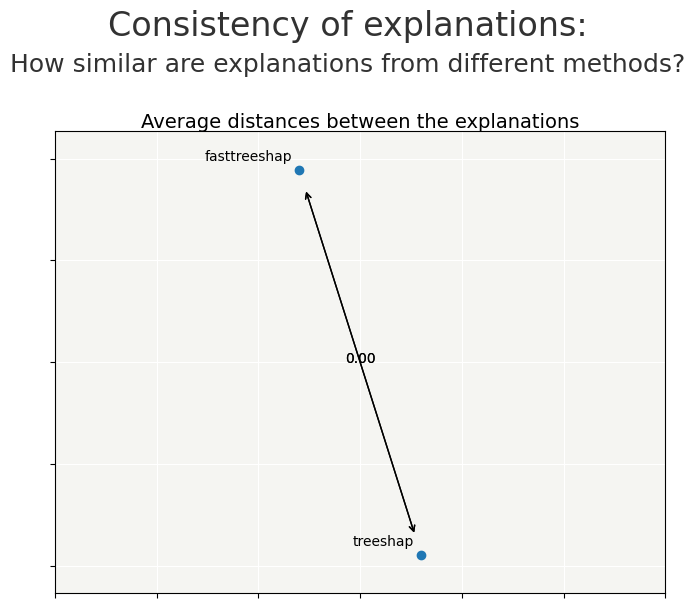

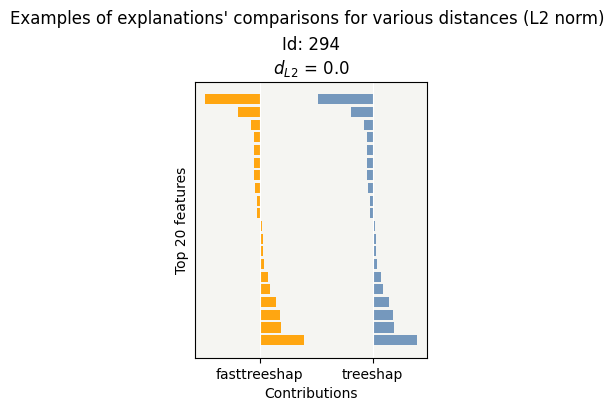

In [20]:
cns = Consistency()
cns.compile(contributions=contributions)
cns.consistency_plot()